**Brian Blaylock**  
**August 30, 2019**

# Converting HRRR GRIB2 data to Zarr

I am experimenting with different ways the HRRR dataset should be chunked with the following considerations.

- Ability to download subsets of the data (smaller regions) or a point.
- Ability to download timeseries at a point or small subset.
- Ability to grab multiple variables.
- Ability to grab data by model run hour (all forecasts) or grab all forecast for a single valid time.

In [109]:
import xarray
import zarr
import matplotlib.pyplot as plt
import numpy as np

In [14]:
import os
os.getcwd()

'/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/demo/zarr'

In [15]:
x = xarray.open_dataset('./HRRRdata/hrrr.t00z.wrfsfcf00.grib2', engine='cfgrib',
                        backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level': 2}))

In [16]:
x1 = xarray.open_dataset('./HRRRdata/hrrr.t00z.wrfsfcf01.grib2', engine='cfgrib',
                        backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'heightAboveGround', 'level': 2}))

Convert the xarray dataset to zarr

In [17]:
x.to_zarr('HRRR_f00.zarr')

In [18]:
# Open the zarr directory
z = zarr.open('HRRR_f00.zarr')

In [98]:
# Tell me some info
z.info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,11
No. arrays,11
No. groups,0
Arrays,"d2m, heightAboveGround, latitude, longitude, pt, q, r2, step, t2m, time, valid_time"


In [20]:
z.attrs.keys()

dict_keys(['Conventions', 'GRIB_centre', 'GRIB_centreDescription', 'GRIB_edition', 'GRIB_subCentre', 'history', 'institution'])

In [44]:
# List the array names (names of folders in zarr directory)
list(z.array_keys())

['d2m',
 'heightAboveGround',
 'latitude',
 'longitude',
 'pt',
 'q',
 'r2',
 'step',
 't2m',
 'time',
 'valid_time']

In [102]:
# Not sure why I can't display the time
z.time

<zarr.core.Array '/time' () int64>

In [21]:
z.t2m.info

Name,/t2m
Type,zarr.core.Array
Data type,float32
Shape,"(1059, 1799)"
Chunk shape,"(265, 450)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,7620564 (7.3M)
No. bytes stored,2182649 (2.1M)


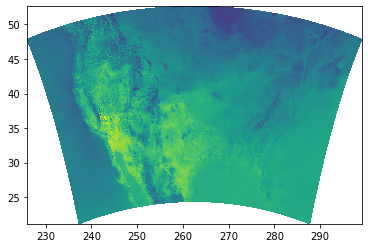

In [58]:
plt.pcolormesh(z.longitude[:], z.latitude[:], z.t2m[:])

In [57]:
z.latitude

<zarr.core.Array '/latitude' (1059, 1799) float64>

In [121]:
from datetime import datetime

In [166]:
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_HRRR.HRRR_Pando import get_hrrr_all_run, get_hrrr_latlon

In [167]:
Hlat, Hlon = get_hrrr_latlon(DICT=False)

In [188]:
H = get_hrrr_all_run(datetime(2019,1,1), "TMP:2 m")

In [189]:
np.shape(H)

(19, 1059, 1799)

In [194]:
Hx = xarray.DataArray(H, dims=('fxx', 'lat', 'lon'), coords={'fxx':range(0,19)})

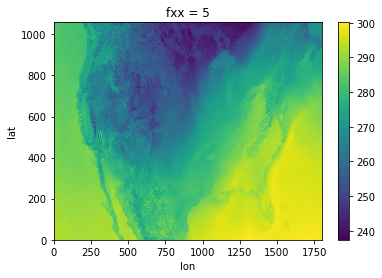

In [195]:
Hx[5].plot()

In [198]:
# Convert to dataset
Hxx = Hx.to_dataset(name='TMP2M')

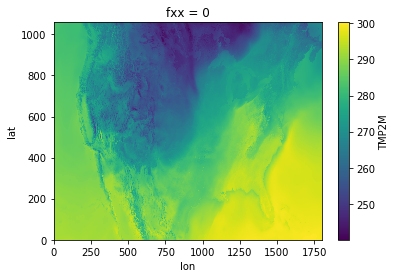

In [203]:
Hxx['TMP2M'][0].plot()

In [204]:
Hxx.to_zarr('HRRR_TMP2m_20190101_t00z.zarr')

In [206]:
zz = zarr.open('HRRR_TMP2m_20190101_t00z.zarr')

In [215]:
zz.TMP2M.info

Name,/TMP2M
Type,zarr.core.Array
Data type,float32
Shape,"(19, 1059, 1799)"
Chunk shape,"(3, 265, 450)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,144790716 (138.1M)
No. bytes stored,44104166 (42.1M)


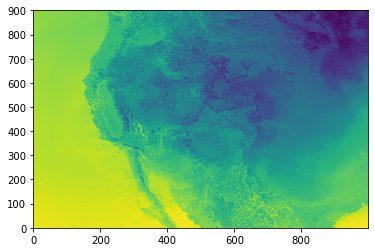

In [225]:
plt.pcolormesh(zz.TMP2M[10, 100:1000, 1:1000])